# Zgradite klasifikacijski model: Slastne azijske in indijske kuhinje


## Razvrščevalniki kuhinj 1

V tej lekciji bomo raziskali različne razvrščevalnike za *napovedovanje določene nacionalne kuhinje na podlagi skupine sestavin.* Pri tem se bomo naučili več o načinih, kako lahko algoritme uporabimo za naloge razvrščanja.

### [**Predhodni kviz**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Priprava**

Ta lekcija temelji na naši [prejšnji lekciji](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb), kjer smo:

-   Naredili uvod v razvrščanje z uporabo nabora podatkov o vseh čudovitih kuhinjah Azije in Indije 😋.

-   Raziskali nekaj [glagolov dplyr](https://dplyr.tidyverse.org/) za pripravo in čiščenje podatkov.

-   Ustvarili čudovite vizualizacije z uporabo ggplot2.

-   Pokazali, kako obravnavati neuravnotežene podatke z njihovo predobdelavo z uporabo [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonstrirali, kako `prep` in `bake` naš recept, da potrdimo, da bo deloval, kot je predvideno.

#### **Predpogoji**

Za to lekcijo bomo potrebovali naslednje pakete za čiščenje, pripravo in vizualizacijo podatkov:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) je [zbirka paketov za R](https://www.tidyverse.org/packages), zasnovana za hitrejše, lažje in bolj zabavno podatkovno znanost!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) je okvir [zbirke paketov](https://www.tidymodels.org/packages/) za modeliranje in strojno učenje.

-   `themis`: Paket [themis](https://themis.tidymodels.org/) ponuja dodatne korake za obdelavo neuravnoteženih podatkov.

-   `nnet`: Paket [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) ponuja funkcije za ocenjevanje nevronskih mrež s povratnim napajanjem z eno skrito plastjo in za modele multinomialne logistične regresije.

Namestite jih lahko tako:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativno spodnji skript preveri, ali imate potrebne pakete za dokončanje tega modula, in jih namesti, če manjkajo.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



Zdaj pa zavihajmo rokave!

## 1. Razdelite podatke na učne in testne sklope.

Začeli bomo z izbiro nekaj korakov iz naše prejšnje lekcije.

### Odstranite najpogostejše sestavine, ki povzročajo zmedo med različnimi kuhinjami, z uporabo `dplyr::select()`.

Vsi obožujemo riž, česen in ingver!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Odlično! Zdaj je čas, da podatke razdelimo tako, da gre 70 % podatkov za učenje in 30 % za testiranje. Pri razdelitvi bomo uporabili tudi tehniko `stratifikacije`, da `ohranimo razmerje posameznih vrst kuhinj` v učnih in validacijskih naborih podatkov.

[rsample](https://rsample.tidymodels.org/), paket v Tidymodels, zagotavlja infrastrukturo za učinkovito razdeljevanje in ponovno vzorčenje podatkov:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Obdelava neuravnoteženih podatkov

Kot ste morda opazili v izvirnem naboru podatkov in našem učnem naboru, je porazdelitev števila kuhinj precej neenakomerna. Korejske kuhinje so *skoraj* 3-krat pogostejše od tajskih kuhinj. Neuravnoteženi podatki pogosto negativno vplivajo na delovanje modela. Veliko modelov najbolje deluje, ko je število opazovanj enako, zato se pogosto spopadajo z izzivi pri obdelavi neuravnoteženih podatkov.

Obstajata dva glavna načina za obdelavo neuravnoteženih naborov podatkov:

-   dodajanje opazovanj v manjšinsko skupino: `Prekomerno vzorčenje` (Over-sampling), na primer z uporabo algoritma SMOTE, ki sintetično generira nove primere manjšinske skupine z uporabo najbližjih sosedov teh primerov.

-   odstranjevanje opazovanj iz večinske skupine: `Podvzorečenje` (Under-sampling)

V naši prejšnji lekciji smo prikazali, kako obdelati neuravnotežene nabore podatkov z uporabo `recepta`. Recept si lahko predstavljamo kot načrt, ki opisuje, katere korake je treba uporabiti na naboru podatkov, da ga pripravimo za analizo. V našem primeru želimo doseči enakomerno porazdelitev števila kuhinj v našem `učnem naboru`. Pojdimo kar k stvari.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Lahko seveda potrdite (z uporabo prep+bake), da bo recept deloval, kot pričakujete - vse oznake kuhinj imajo `559` opazovanj.

Ker bomo ta recept uporabljali kot predprocesor za modeliranje, bo `workflow()` opravil vse priprave in peko namesto nas, tako da recepta ne bomo morali ročno ocenjevati.

Zdaj smo pripravljeni na treniranje modela 👩‍💻👨‍💻!

## 3. Izbira vašega klasifikatorja

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Umetniško delo @allison_horst</figcaption>


Zdaj moramo odločiti, kateri algoritem uporabiti za nalogo 🤔.

V Tidymodels [`parsnip package`](https://parsnip.tidymodels.org/index.html) zagotavlja dosleden vmesnik za delo z modeli prek različnih pogonov (paketov). Prosimo, preglejte dokumentacijo parsnip za raziskovanje [vrst modelov in pogonov](https://www.tidymodels.org/find/parsnip/#models) ter njihovih ustreznih [argumentov modelov](https://www.tidymodels.org/find/parsnip/#model-args). Raznolikost je na prvi pogled precej osupljiva. Na primer, naslednje metode vključujejo tehnike klasifikacije:

-   C5.0 modeli klasifikacije na osnovi pravil

-   Prilagodljivi diskriminantni modeli

-   Linearni diskriminantni modeli

-   Regularizirani diskriminantni modeli

-   Logistični regresijski modeli

-   Multinomialni regresijski modeli

-   Naivni Bayesovi modeli

-   Podporni vektorski stroji

-   Najbližji sosedje

-   Odločitvena drevesa

-   Metode ansambla

-   Nevronske mreže

Seznam se nadaljuje!

### **Kateri klasifikator izbrati?**

Torej, kateri klasifikator bi morali izbrati? Pogosto je preizkušanje več klasifikatorjev in iskanje dobrega rezultata način testiranja.

> AutoML to težavo elegantno reši z izvajanjem teh primerjav v oblaku, kar vam omogoča izbiro najboljšega algoritma za vaše podatke. Preizkusite ga [tukaj](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Izbira klasifikatorja je odvisna tudi od našega problema. Na primer, kadar je rezultat mogoče razvrstiti v `več kot dva razreda`, kot v našem primeru, morate uporabiti `algoritem za večrazredno klasifikacijo` namesto `binarne klasifikacije.`

### **Boljši pristop**

Boljši način kot naključno ugibanje je, da sledite idejam iz te prenosljive [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Tukaj odkrijemo, da imamo za naš večrazredni problem nekaj možnosti:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Del Microsoftovega algoritmičnega priročnika, ki podrobno opisuje možnosti večrazredne klasifikacije</figcaption>


### **Razmišljanje**

Poglejmo, ali lahko z razmišljanjem najdemo različne pristope glede na omejitve, ki jih imamo:

-   **Globoke nevronske mreže so pretežke**. Glede na naš čist, a minimalen nabor podatkov ter dejstvo, da izvajamo učenje lokalno prek beležk, so globoke nevronske mreže za to nalogo preveč zahtevne.

-   **Brez klasifikatorja z dvema razredoma**. Ne uporabljamo klasifikatorja z dvema razredoma, kar izključuje pristop "ena proti vsem".

-   **Odločilno drevo ali logistična regresija bi lahko delovala**. Odločilno drevo bi lahko delovalo, prav tako multinomna regresija/multirazredna logistična regresija za podatke z več razredi.

-   **Multirazredna izboljšana odločilna drevesa rešujejo drugačen problem**. Multirazredna izboljšana odločilna drevesa so najbolj primerna za neparametrične naloge, npr. naloge, namenjene gradnji razvrstitev, zato za nas niso uporabna.

Poleg tega je običajno, preden se lotimo bolj zapletenih modelov strojnega učenja, kot so metode ansambla, dobro zgraditi čim bolj preprost model, da dobimo občutek, kaj se dogaja. Zato bomo v tej lekciji začeli z modelom `multinomne regresije`.

> Logistična regresija je tehnika, ki se uporablja, kadar je odvisna spremenljivka kategorična (ali nominalna). Pri binarni logistični regresiji je število izhodnih spremenljivk dve, medtem ko je število izhodnih spremenljivk pri multinomni logistični regresiji več kot dve. Za več informacij glejte [Napredne metode regresije](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html).

## 4. Učenje in ocenjevanje modela multinomne logistične regresije

V Tidymodels `parsnip::multinom_reg()` definira model, ki uporablja linearne napovedovalce za napovedovanje podatkov z več razredi z uporabo multinomne porazdelitve. Glejte `?multinom_reg()` za različne načine/motorje, ki jih lahko uporabite za prilagoditev tega modela.

Za ta primer bomo prilagodili model multinomne regresije prek privzetega motorja [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Vrednost za `penalty` sem izbral bolj naključno. Obstajajo boljši načini za izbiro te vrednosti, in sicer z uporabo `resampling` in `tuning` modela, o čemer bomo razpravljali kasneje.
>
> Glejte [Tidymodels: Začetek](https://www.tidymodels.org/start/tuning/), če želite izvedeti več o tem, kako nastaviti hiperparametre modela.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Odlično delo 🥳! Zdaj, ko imamo recept in specifikacijo modela, moramo najti način, kako ju združiti v objekt, ki bo najprej predprocesiral podatke, nato prilagodil model na predprocesirane podatke in omogočil tudi morebitne aktivnosti po obdelavi. V Tidymodels se ta priročen objekt imenuje [`workflow`](https://workflows.tidymodels.org/) in priročno združuje vaše modelne komponente! To je tisto, kar bi v *Pythonu* imenovali *pipelines*.

Torej, združimo vse v workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Poteki dela 👌👌! **`workflow()`** se lahko prilagodi na skoraj enak način kot model. Torej, čas je za treniranje modela!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Izhod prikazuje koeficiente, ki jih je model naučil med usposabljanjem.

### Ovrednotite usposobljeni model

Čas je, da preverimo, kako se je model odrezal 📏, tako da ga ovrednotimo na testnem naboru podatkov! Začnimo z napovedovanjem na testnem naboru.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Odlično delo! V Tidymodels lahko ocenjujemo uspešnost modela z uporabo [yardstick](https://yardstick.tidymodels.org/) - paketa, ki se uporablja za merjenje učinkovitosti modelov z uporabo metrik uspešnosti. Kot smo storili v naši lekciji o logistični regresiji, začnimo z izračunom matrike zmede.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Ko se ukvarjamo z več razredi, je na splošno bolj intuitivno to vizualizirati kot toplotni zemljevid, takole:


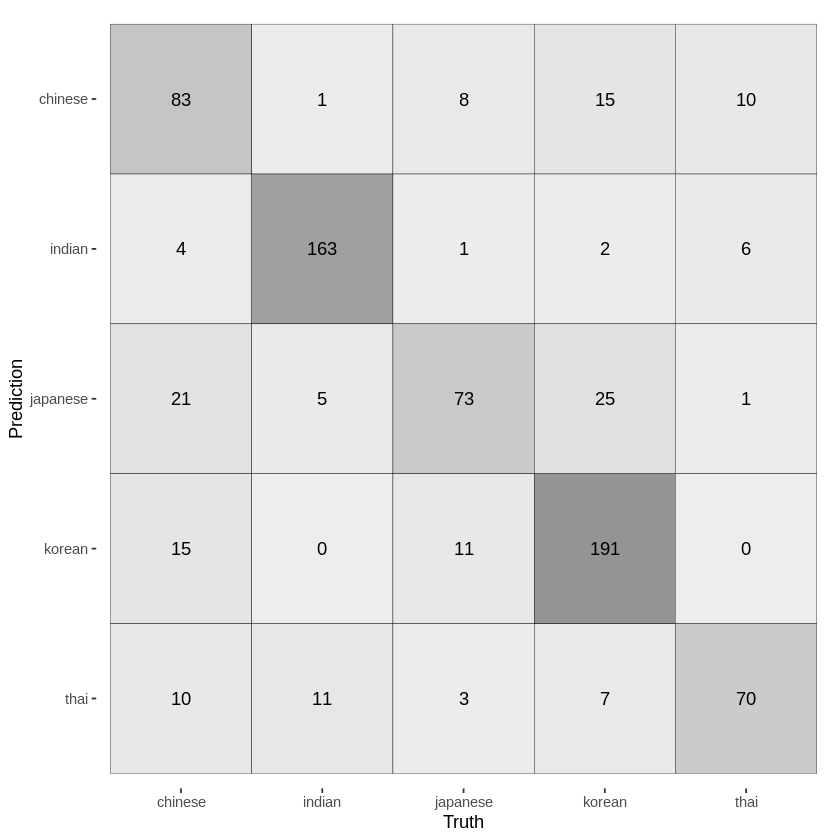

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Temnejši kvadrati v grafu matrike zmede označujejo veliko število primerov, in upamo, da lahko vidite diagonalno črto temnejših kvadratov, ki označuje primere, kjer sta napovedana in dejanska oznaka enaka.

Zdaj pa izračunajmo povzetne statistike za matriko zmede.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Če se osredotočimo na nekatere metrike, kot so natančnost, občutljivost, ppv, smo za začetek kar dobro na poti 🥳!

## 4. Poglabljanje

Postavimo si eno subtilno vprašanje: Katera merila se uporabljajo za izbiro določene vrste kuhinje kot napovedanega rezultata?

Statistični algoritmi strojnega učenja, kot je logistična regresija, temeljijo na `verjetnosti`; torej, kar dejansko napove klasifikator, je porazdelitev verjetnosti med naborom možnih rezultatov. Razred z najvišjo verjetnostjo je nato izbran kot najbolj verjeten rezultat za dane opazovanja.

Poglejmo to v praksi, tako da naredimo trde napovedi razredov in verjetnosti.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Veliko bolje!

✅ Ali lahko razložiš, zakaj je model precej prepričan, da je prva opazka tajska?

## **🚀Izziv**

V tej lekciji si uporabil_a očiščene podatke za izdelavo modela strojnega učenja, ki lahko napove nacionalno kuhinjo na podlagi serije sestavin. Vzemi si nekaj časa in preglej [številne možnosti](https://www.tidymodels.org/find/parsnip/#models), ki jih Tidymodels ponuja za klasifikacijo podatkov, ter [druge načine](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) za prilagoditev multinomnih regresijskih modelov.

#### HVALA:

[`Allison Horst`](https://twitter.com/allison_horst/) za ustvarjanje neverjetnih ilustracij, ki naredijo R bolj prijazen in privlačen. Več ilustracij najdeš v njeni [galeriji](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) in [Jen Looper](https://www.twitter.com/jenlooper) za ustvarjanje izvirne Python različice tega modula ♥️

<br>
Dodal_a bi nekaj šal, ampak ne razumem hrane-punov 😅.

<br>

Veselo učenje,

[Eric](https://twitter.com/ericntay), zlati Microsoft Learn študentski ambasador.



---

**Omejitev odgovornosti**:  
Ta dokument je bil preveden z uporabo storitve za strojno prevajanje [Co-op Translator](https://github.com/Azure/co-op-translator). Čeprav si prizadevamo za natančnost, vas prosimo, da upoštevate, da lahko avtomatizirani prevodi vsebujejo napake ali netočnosti. Izvirni dokument v njegovem izvirnem jeziku je treba obravnavati kot avtoritativni vir. Za ključne informacije priporočamo strokovno človeško prevajanje. Ne prevzemamo odgovornosti za morebitna nesporazumevanja ali napačne razlage, ki izhajajo iz uporabe tega prevoda.
